In [32]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.keras import datasets
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, LSTM, Bidirectional
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import metrics
from tensorflow.keras.callbacks import EarlyStopping

In [33]:
np.random.seed(123)
tf.random.set_seed(123)

mnist = datasets.mnist
(x_train, t_train), (x_test, t_test) = mnist.load_data()

x_train = (x_train.reshape(-1, 28, 28) / 255).astype(np.float32)
x_test = (x_test.reshape(-1, 28, 28) / 255).astype(np.float32)

x_train, x_val, t_train, t_val = \
    train_test_split(x_train, t_train, test_size=0.2)

print(t_train)

[3 2 0 ... 0 9 4]


In [34]:
class BiRNN(Model):
    def __init__(self, hidden_dim):
        super().__init__()
        self.l1 = Bidirectional(LSTM(hidden_dim, activation='tanh',
                                     recurrent_activation='sigmoid',
                                     kernel_initializer='glorot_normal',
                                     recurrent_initializer='orthogonal'),
                                merge_mode='concat')
        self.l2 = Dense(10, kernel_initializer='glorot_normal',
                        activation='softmax')

    def call(self, x):
        h = self.l1(x)
        y = self.l2(h)
        return y

model = BiRNN(25)

criterion = losses.SparseCategoricalCrossentropy()
optimizer = optimizers.Adam(learning_rate=0.001,
                                beta_1=0.9, beta_2=0.999, amsgrad=True)
train_loss = metrics.Mean()
train_acc = metrics.SparseCategoricalAccuracy()
val_loss = metrics.Mean()
val_acc = metrics.SparseCategoricalAccuracy()

In [35]:
def compute_loss(t, y):
    return criterion(t, y)

def train_step(x, t):
    with tf.GradientTape() as tape:
        preds = model(x)
        loss = compute_loss(t, preds)
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    train_loss(loss)
    train_acc(t, preds)

    return loss

def val_step(x, t):
    preds = model(x)
    loss = compute_loss(t, preds)
    val_loss(loss)
    val_acc(t, preds)
    
#epochs = 1000
epochs = 16
batch_size = 100
n_batches_train = x_train.shape[0] // batch_size
n_batches_val = x_val.shape[0] // batch_size
hist = {'loss': [], 'accuracy': [],
        'val_loss': [], 'val_accuracy': []}
es = EarlyStopping(patience=5, verbose=1)

In [36]:
for epoch in range(epochs):
    x_, t_ = shuffle(x_train, t_train)

    for batch in range(n_batches_train):
        start = batch * batch_size
        end = start + batch_size
        train_step(x_[start:end], t_[start:end])

    for batch in range(n_batches_val):
        start = batch * batch_size
        end = start + batch_size
        val_step(x_val[start:end], t_val[start:end])

    hist['loss'].append(train_loss.result())
    hist['accuracy'].append(train_acc.result())
    hist['val_loss'].append(val_loss.result())
    hist['val_accuracy'].append(val_acc.result())

    print('epoch: {}, loss: {:.3}, acc: {:.3f}'
          ', val_loss: {:.3}, val_acc: {:.3f}'.format(
              epoch+1,
              train_loss.result(),
              train_acc.result(),
              val_loss.result(),
              val_acc.result()
          ))

#    if es(val_loss.result()):
#            break

epoch: 1, loss: 0.968, acc: 0.692, val_loss: 0.445, val_acc: 0.867
epoch: 2, loss: 0.648, acc: 0.797, val_loss: 0.353, val_acc: 0.893
epoch: 3, loss: 0.503, acc: 0.844, val_loss: 0.303, val_acc: 0.908
epoch: 4, loss: 0.418, acc: 0.871, val_loss: 0.266, val_acc: 0.919
epoch: 5, loss: 0.362, acc: 0.889, val_loss: 0.244, val_acc: 0.927
epoch: 6, loss: 0.322, acc: 0.901, val_loss: 0.223, val_acc: 0.933
epoch: 7, loss: 0.291, acc: 0.911, val_loss: 0.207, val_acc: 0.938
epoch: 8, loss: 0.267, acc: 0.918, val_loss: 0.195, val_acc: 0.942
epoch: 9, loss: 0.247, acc: 0.925, val_loss: 0.185, val_acc: 0.945
epoch: 10, loss: 0.23, acc: 0.930, val_loss: 0.176, val_acc: 0.948
epoch: 11, loss: 0.216, acc: 0.934, val_loss: 0.169, val_acc: 0.950
epoch: 12, loss: 0.204, acc: 0.938, val_loss: 0.163, val_acc: 0.952
epoch: 13, loss: 0.193, acc: 0.941, val_loss: 0.158, val_acc: 0.953
epoch: 14, loss: 0.184, acc: 0.944, val_loss: 0.153, val_acc: 0.955
epoch: 15, loss: 0.176, acc: 0.947, val_loss: 0.149, val_a

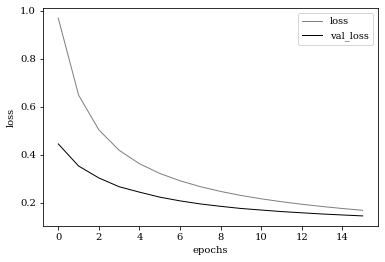

test_loss: 0.080, test_acc: 0.976


In [37]:
# 検証データの誤差の可視化
loss = hist['loss']
val_loss = hist['val_loss']

fig = plt.figure()
plt.rc('font', family='serif')
plt.plot(range(len(loss)), loss,
         color='gray', linewidth=1,
         label='loss')
plt.plot(range(len(val_loss)), val_loss,
         color='black', linewidth=1,
         label='val_loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
# plt.savefig('output.jpg')
plt.show()

# テストデータの評価
test_loss = metrics.Mean()
test_acc = metrics.SparseCategoricalAccuracy()

def test_step(x, t):
    preds = model(x)
    loss = compute_loss(t, preds)
    test_loss(loss)
    test_acc(t, preds)

    return loss

test_step(x_test, t_test)

print('test_loss: {:.3f}, test_acc: {:.3f}'.format(
    test_loss.result(),
    test_acc.result()
))